In [2]:
#Import packages and resources
import os
import sys
import json
import requests
import time
import datetime
import math
import pandas as pd
import numpy as np
import serial
import importlib
import matplotlib.pyplot as plt
import dash
import plotly.graph_objs as go
from functions.PitotProcess import PitotProcess
from functions.filtrar_datos_real_vert import filtrar_datos_vertical
from functions.V_Wind import V_Wind
from functions.Cb_e import C_b_e
from IPython.display import clear_output
from dash import dcc, html
from dash.dependencies import Output, Input


In [3]:
%reload_ext autoreload
%autoreload 2

**CONFIGURATION A REFERENCE SYSTEM CUBESAT SPACEPORT VOLTA**
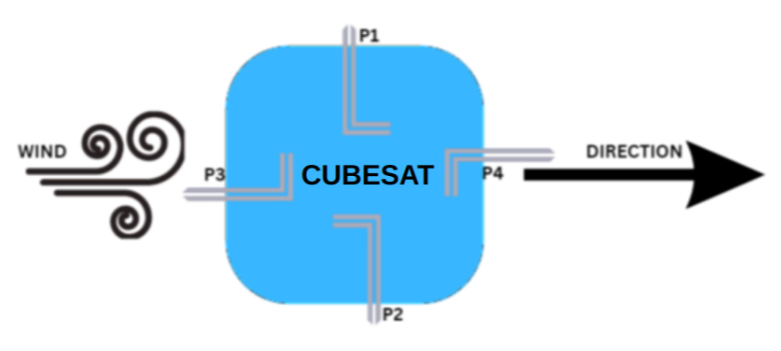

In [4]:
'''#LISTENING TO THE DATA
#Get the data from the ARDUINO BOARD
#seting up the serial connection
puerto = 'COM7' #'COM7'  
baudios = 9600  # Verifer in the Arduino IDE
timeout = 1  # time to wait for the data
#ser = serial.Serial(puerto, baudios, timeout=timeout)# WINDOS ONLY
arduino = serial.Serial(port='/dev/ttyS0', baudrate=9600, timeout=1)#LINUX ONLY'''

"#LISTENING TO THE DATA\n#Get the data from the ARDUINO BOARD\n#seting up the serial connection\npuerto = 'COM7' #'COM7'  \nbaudios = 9600  # Verifer in the Arduino IDE\ntimeout = 1  # time to wait for the data\n#ser = serial.Serial(puerto, baudios, timeout=timeout)# WINDOS ONLY\narduino = serial.Serial(port='/dev/ttyS0', baudrate=9600, timeout=1)#LINUX ONLY"

In [5]:
# Define the columns
column_names = ["P_1","P_2","P_3","P_4","T_1","T_2","T_3","T_4","phi","theta","psi","gpx_vx","gps_vy","gps_vz","coordinates_gps","IMU_vx","IMU_vy","IMU_vz","Timestamp"]

# Create an empty DataFrame
datos = pd.DataFrame(columns=column_names)

In [6]:
#DEFINE STATICAL CONDITIONS, OFFSET VALUES AND CONSTANTS
offset_pitots = [0, 0, 0, 0] #Pitot offset values
offset_IMU = [0, 0, 0] #IMU offset values
offset_GPS = [0, 0, 0] #GPS offset values
local_pressure = 101325 #Pa
R = 287.05 #J/(kg*K)
T = 273.15 #K
g = 9.81 #m/s^2
rho = 1.225 #kg/m^3

In [ ]:

# Inicializar la app de Dash
app = dash.Dash(__name__)
server = app.server

app.layout = html.Div([
    html.H1("Simulación de Vectores de Viento en Tiempo Real"),
    dcc.Graph(id='live-graph', style={'height': '70vh'}),
    dcc.Interval(
        id='interval-component',
        interval=500,  # Actualización cada 500 ms
        n_intervals=0
    ),
    html.Div(id='live-update-text')
])

@app.callback(
    [Output('live-graph', 'figure'),
     Output('live-update-text', 'children')],
    [Input('interval-component', 'n_intervals')]
)
def update_graph_live(n):
    global datos
    try:
        while True:
            if arduino.in_waiting > 0:
                raw_data = arduino.readline().decode('utf-8').strip()  # read the data from the arduino
                print(f"Data received: {raw_data}")
                
                # Split the data into a list of strings
                data_list = raw_data.split(',')
            
                # verify that the data is complete
                if len(data_list) == len(column_names):
                    # Convertir datos numéricos
                    try:
                        numeric_data = [pd.to_numeric(value, errors='coerce') for value in data_list]#convert to numeric
                        data_dict = dict(zip(column_names, numeric_data))#create a dictionary
                        datos = pd.concat([datos, pd.DataFrame([data_dict])], ignore_index=True)#add the data to the DataFrame
                        datos['Timestamp'] = pd.to_datetime(datos['Timestamp'], unit='s', errors='coerce')
                        datos = datos.iloc[-34:, :] 
                        if len(datos) >= 34:
                            
                            #show data in real time
                            pitots_data = numeric_data[0:4]
                            temp_data = numeric_data[4:8]
                            Eulerangle_data = numeric_data[8:11]
                            IMU_Vel_data = numeric_data[15:18]
                            GPS_Vel_data = numeric_data[11:14]
                            GPS_data = numeric_data[14]
                            
                            #IMU process 
                            euler_angles = [Eulerangle_data[0], Eulerangle_data[1], Eulerangle_data[2]] #NOTA: LA IMU DEBE PROPORCIONAR VALORES DE VELOCIDAD, REQUIERE FILTRO?
                            V_IMU = C_b_e(IMU_Vel_data, euler_angles)
                            imu_w = 0 #NOTA: THIS IS THE WEIGHT OF THE IMU IN THE MEASUREMENTS OF THE WIND SPEED, ALGOTITHM TO REGULATE SHOULD BE DEVELOPED
                            
                            #GPS process #NOTA_ el GPS debe proporcionar la velocidad en el sistema de coordenadas de la tierra y requiere filtro?
                            V_GPS = [GPS_Vel_data[0], GPS_Vel_data[1], GPS_Vel_data[2]]
                            gps_w = 0 #NOTA: THIS IS THE WEIGHT OF THE GPS IN THE MEASUREMENTS OF THE WIND SPEED, ALGOTITHM TO REGULATE SHOULD BE DEVELOPED
                            
                            #Pitot process
                            filtered_data, datos = filtrar_datos_vertical(pitots_data,datos[0:4], offset_pitots)
                            localtemp_pitot = temp_data.mean()#NOTA: ESTE VALOR LO ENTREGAN LOS PITOTS?
                            rho_prime = (local_pressure*0.02897)/(8.314472*(localtemp_pitot+273.15))
                            velocity_pitots = list(map(lambda x: ((2*abs(x)/rho_prime)**0.5), filtered_data))
                            proccessed_pitot_couples = PitotProcess(filtered_data,local_pressure,localtemp_pitot,euler_angles)

                            #TRANSFORM TO EARTH FRAME
                            V_wind = V_Wind(proccessed_pitot_couples,GPS_Vel_data, gps_w, V_IMU, imu_w)
                            V_Wind_earthsystem = C_b_e(V_wind, euler_angles)
                            datos.iloc[-1, :4] = filtered_data
                            # Mostrar resultados en tiempo real
                            clear_output(wait=True)
                            print(f"Pitots: {pitots_data} \n IMU: {Eulerangle_data} \n GPS_vel: {GPS_Vel_data} \n Viento en tierra: {V_Wind_earthsystem}")
                            # Graficar vectores
                            fig = go.Figure(data=[
                                go.Scatter3d(x=[0, GPS_Vel_data[0]], y=[0, GPS_Vel_data[1]], z=[0, GPS_Vel_data[2]],
                                            mode='lines+markers', name='GPS'),
                                go.Scatter3d(x=[0, IMU_Vel_data[0]], y=[0, IMU_Vel_data[1]], z=[0, IMU_Vel_data[2]],
                                            mode='lines+markers', name='IMU'),
                                go.Scatter3d(x=[0, proccessed_pitot_couples[0][0]], y=[0, proccessed_pitot_couples[0][1]], z=[0, proccessed_pitot_couples[0][2]],
                                            mode='lines+markers', name='Viento')
                            ])
                            fig.update_layout(
                                margin=dict(l=0, r=0, b=0, t=0),
                                scene=dict(
                                    xaxis_title='X',
                                    yaxis_title='Y',
                                    zaxis_title='Z'
                                )
                            )
                        time.sleep(0.5)  # Simular lectura en tiempo real
                        text = f"Pitots: {pitots_data} | Euler: {Eulerangle_data} | GPS: {GPS_Vel_data} | IMU: {IMU_Vel_data} | Viento: {viento.tolist()}"
                        return fig, text
                        
                    except ValueError:
                        print("Error converting DATA:", data_list)
                else:
                    print(f"Datos incompletos: {data_list}")
    
    except KeyboardInterrupt:
        print("Lectura finalizada.")
        arduino.close() 
# Ejecutar la app
if __name__ == '__main__':
    app.run_server(debug=True)


'\n# Inicializar la app de Dash\napp = dash.Dash(__name__)\nserver = app.server\n\napp.layout = html.Div([\n    html.H1("Simulación de Vectores de Viento en Tiempo Real"),\n    dcc.Graph(id=\'live-graph\', style={\'height\': \'70vh\'}),\n    dcc.Interval(\n        id=\'interval-component\',\n        interval=500,  # Actualización cada 500 ms\n        n_intervals=0\n    ),\n    html.Div(id=\'live-update-text\')\n])\n\n@app.callback(\n    [Output(\'live-graph\', \'figure\'),\n     Output(\'live-update-text\', \'children\')],\n    [Input(\'interval-component\', \'n_intervals\')]\n)\ndef update_graph_live(n):\n    global datos\n    try:\n        while True:\n            if arduino.in_waiting > 0:\n                raw_data = arduino.readline().decode(\'utf-8\').strip()  # read the data from the arduino\n                print(f"Data received: {raw_data}")\n                \n                # Split the data into a list of strings\n                data_list = raw_data.split(\',\')\n           

In [ ]:
'''import dash
from dash import dcc, html, Output, Input
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import time

# Inicializar la app de Dash
app = dash.Dash(__name__)
server = app.server

datos = pd.DataFrame()

# Diseño de la aplicación con pestañas
app.layout = html.Div([
    html.H1("Simulador Aeroespacial Interactivo"),
    dcc.Tabs([
        dcc.Tab(label='Simulación de Vectores de Viento', children=[
            dcc.Graph(id='live-graph', style={'height': '70vh'}),
            dcc.Interval(
                id='interval-component-viento',
                interval=1000,  # Actualización cada segundo
                n_intervals=0
            ),
            html.Div(id='live-update-text')
        ]),
        dcc.Tab(label='Simulación de Viento Impactando un Satélite', children=[
            dcc.Graph(id='cubo-simulacion'),
            dcc.Interval(
                id='interval-component-satelite',
                interval=5000,  # Actualización cada 5 segundos
                n_intervals=0
            )
        ])
    ])
])

# Callback para la simulación de vectores de viento
@app.callback(
    [Output('live-graph', 'figure'),
     Output('live-update-text', 'children')],
    [Input('interval-component-viento', 'n_intervals')]
)
def update_graph_live(n):
    viento = np.random.uniform(-10, 10, 3)
    velocidad = np.random.uniform(-5, 5, 3)

    fig = go.Figure(data=[
        go.Scatter3d(x=[0, viento[0]], y=[0, viento[1]], z=[0, viento[2]],
                      mode='lines+markers', name='Viento'),
        go.Scatter3d(x=[0, velocidad[0]], y=[0, velocidad[1]], z=[0, velocidad[2]],
                      mode='lines+markers', name='Velocidad del cuerpo')
    ])

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    text = f"Viento: {viento} | Velocidad: {velocidad}"
    return fig, text

# Callback para la simulación del impacto en el satélite
@app.callback(
    Output('cubo-simulacion', 'figure'),
    Input('interval-component-satelite', 'n_intervals')
)
def actualizar_grafico(n):
    viento = np.random.uniform(-5, 5, 3)
    velocidad = np.random.uniform(-2, 2, 3)

    x = [0, 5, 5, 0, 0, 5, 5, 0]
    y = [0, 0, 5, 5, 0, 0, 5, 5]
    z = [0, 0, 0, 0, 5, 5, 5, 5]

    cubo = go.Mesh3d(
        x=x, y=y, z=z,
        color='lightblue',
        opacity=0.8
    )

    viento_vector = go.Cone(
        x=[0.5], y=[0.5], z=[0.5],
        u=[viento[0]], v=[viento[1]], w=[viento[2]],
        sizemode="scaled", sizeref=0.5,
        colorscale='Reds', showscale=True
    )

    velocidad_vector = go.Cone(
        x=[0.5], y=[0.5], z=[0.5],
        u=[velocidad[0]], v=[velocidad[1]], w=[velocidad[2]],
        sizemode="scaled", sizeref=0.5,
        colorscale='Blues', showscale=True
    )

    fig = go.Figure(data=[cubo, viento_vector, velocidad_vector])
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[-5, 5]),
            yaxis=dict(range=[-5, 5]),
            zaxis=dict(range=[-5, 5])
        ),
        title="Impacto de Viento y Movimiento en un Satélite"
    )
    return fig

# Ejecutar la app
if __name__ == '__main__':
    app.run_server(debug=True)'''

In [ ]:
# Initialize Dash app
'''app = dash.Dash(__name__)
server = app.server

# Layout configuration with two graphs
app.layout = html.Div([
    html.H1("Real-Time Wind Vector Simulation"),
    dcc.Graph(id='velocity-vectors-graph', style={'height': '40vh'}),
    dcc.Graph(id='wind-impact-graph', style={'height': '40vh'}),
    dcc.Interval(
        id='interval-component',
        interval=500,  # Update every 500 ms
        n_intervals=0
    ),
    html.Div(id='live-update-text')
])

# Callback to update both graphs in real-time
@app.callback(
    [Output('velocity-vectors-graph', 'figure'),
     Output('wind-impact-graph', 'figure'),
     Output('live-update-text', 'children')],
    [Input('interval-component', 'n_intervals')]
)
def update_graphs_live(n):
    global datos
    try:
        while True:
            if arduino.in_waiting > 0:
                raw_data = arduino.readline().decode('utf-8').strip()  # Read data from Arduino
                print(f"Data received: {raw_data}")

                # Split the data into a list of strings
                data_list = raw_data.split(',')

                # Verify that the data is complete
                if len(data_list) == len(column_names):
                    try:
                        # Convert data to numeric values
                        numeric_data = [pd.to_numeric(value, errors='coerce') for value in data_list]
                        data_dict = dict(zip(column_names, numeric_data))
                        datos = pd.concat([datos, pd.DataFrame([data_dict])], ignore_index=True)
                        datos['Timestamp'] = pd.to_datetime(datos['Timestamp'], unit='s', errors='coerce')
                        datos = datos.iloc[-34:, :]  # Keep the last 34 entries

                        if len(datos) >= 34:
                            # Extract relevant data
                            pitots_data = numeric_data[0:4]
                            temp_data = numeric_data[4:8]
                            Eulerangle_data = numeric_data[8:11]
                            IMU_Vel_data = numeric_data[15:18]
                            GPS_Vel_data = numeric_data[11:14]
                            GPS_data = numeric_data[14]

                            # IMU process
                            euler_angles = [Eulerangle_data[0], Eulerangle_data[1], Eulerangle_data[2]]
                            V_IMU = C_b_e(IMU_Vel_data, euler_angles)
                            imu_w = 0  # Weight of the IMU in wind speed measurement (to be developed)

                            # GPS process
                            V_GPS = [GPS_Vel_data[0], GPS_Vel_data[1], GPS_Vel_data[2]]
                            gps_w = 0  # Weight of the GPS in wind speed measurement (to be developed)

                            # Pitot process
                            filtered_data, datos = filtrar_datos_vertical(pitots_data, datos[0:4], offset_pitots)
                            localtemp_pitot = temp_data.mean()
                            rho_prime = (local_pressure * 0.02897) / (8.314472 * (localtemp_pitot + 273.15))
                            velocity_pitots = list(map(lambda x: ((2 * abs(x) / rho_prime) ** 0.5), filtered_data))
                            proccessed_pitot_couples = PitotProcess(filtered_data, local_pressure, localtemp_pitot, euler_angles)

                            # Transform to Earth frame
                            V_wind = V_Wind(proccessed_pitot_couples, GPS_Vel_data, gps_w, V_IMU, imu_w)
                            V_Wind_earthsystem = C_b_e(V_wind, euler_angles)
                            datos.iloc[-1, :4] = filtered_data

                            # Display real-time results
                            clear_output(wait=True)
                            print(f"Pitots: {pitots_data} \n IMU: {Eulerangle_data} \n GPS_vel: {GPS_Vel_data} \n Wind on Earth: {V_Wind_earthsystem}")

                            # Plot velocity vectors
                            velocity_fig = go.Figure(data=[
                                go.Scatter3d(x=[0, GPS_Vel_data[0]], y=[0, GPS_Vel_data[1]], z=[0, GPS_Vel_data[2]],
                                             mode='lines+markers', name='GPS'),
                                go.Scatter3d(x=[0, IMU_Vel_data[0]], y=[0, IMU_Vel_data[1]], z=[0, IMU_Vel_data[2]],
                                             mode='lines+markers', name='IMU'),
                                go.Scatter3d(x=[0, proccessed_pitot_couples[0][0]], y=[0, proccessed_pitot_couples[0][1]], z=[0, proccessed_pitot_couples[0][2]],
                                             mode='lines+markers', name='Wind')
                            ])
                            velocity_fig.update_layout(
                                margin=dict(l=0, r=0, b=0, t=0),
                                scene=dict(
                                    xaxis_title='X',
                                    yaxis_title='Y',
                                    zaxis_title='Z'
                                )
                            )

                            # Plot wind impact visualization
                            wind_impact_fig = go.Figure(data=[
                                go.Cone(x=[0], y=[0], z=[0],
                                        u=[V_Wind_earthsystem[0]], v=[V_Wind_earthsystem[1]], w=[V_Wind_earthsystem[2]],
                                        sizemode="absolute", sizeref=2, anchor="tail", name='Wind Impact')
                            ])
                            wind_impact_fig.update_layout(
                                margin=dict(l=0, r=0, b=0, t=0),
                                scene=dict(
                                    xaxis_title='X',
                                    yaxis_title='Y',
                                    zaxis_title='Z'
                                )
                            )

                        time.sleep(0.5)  # Simulate real-time reading
                        text = f"Pitots: {pitots_data} | Euler: {Eulerangle_data} | GPS: {GPS_Vel_data} | IMU: {IMU_Vel_data} | Wind: {V_Wind_earthsystem.tolist()}"
                        return velocity_fig, wind_impact_fig, text

                    except ValueError:
                        print("Error converting DATA:", data_list)
                else:
                    print(f"Incomplete data: {data_list}")

    except KeyboardInterrupt:
        print("Reading finished.")
        arduino.close()

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

'''